# Dark Frame Calibration

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tifffile import imwrite
import math


import sys
sys.path.append('../tauSWIRcamera')  # Add the path to the directory containing file_to_import.py
from tauSWIRcamera import tauSWIRcamera

plt.rcParams["font.family"] = "Times New Roman"

### Initialize Camera with Default Settings

In [2]:

hostname = '129.123.5.125'
port = 4000
cam = tauSWIRcamera(hostname, port, "MASTER")
cameraFolder = cam.name

## START CAMERA SETUP ##
1. Analog mode set to: DISABLED
2. External Sync Mode set to: MASTER
3. AGC set to: MANUAL
4. Auto-Exposure set to: DISABLED
5. CMOS bit depth set to: 14-BITS
6. Camera Link bit depth set to: 14-BITS
7. Integration mode set to: UNRESTRICTED
8. FPA Set Point Temperature set to: 20oC
9. Settings set as Power-on Default
## CAMERA SETUP COMPLETED ##


## Data Acquisition

In [4]:
def runDarkFrameAnalysis(gain, N=50, fps=30, saveTIFdata=False, savePlot=False):

    ### Set gain ###
    cam.setSensorGain(gain)

    ### Set FPS ###
    cam.setFPS(fps)
    
    # Integration time vector
    intTime_ms = np.linspace(1,30,30)
    intTime_ms = np.insert(intTime_ms, 0, 0.011)

    # FPA possible setpoint temperatures
    FPA_temp_setpoint_options = [0, 20, 40, 45] #oC


    fig, ax = plt.subplots()
    marker = {20: '-o', 40:'-s'}
    color = {20: 'blue',40:'red'}
    for fpaTemp in [20, 40]:
        # Set FPA setpoint temp
        print(f"Set FPA temp to {fpaTemp}oC")
        cam.setFPATempSetPoint(FPA_temp_setpoint_options.index(fpaTemp))
        df_mean  = np.array([])
        df_mean_estimated = np.array([])
        df_std  = np.array([])
        df_estimated_std = np.array([])
        for t_ms in intTime_ms:
            if intTime_ms >= math.floor(1e3/fps):
                break
            # Set Integration Time
            print(f"Set integration time to {t_ms}")
            cam.setIntTime(t_ms)
            # Collect frames
            df_stack = cam.collectFrame(N)
            # Save the stack of images as a multi-page TIFF file
            if saveTIFdata:
                imwrite(f'{cameraFolder}/{fps}fps/{cameraFolder}_stack_{N}images_{gain}gain_FPA_at{fpaTemp}C_expTime_{t_ms}ms.tif', df_stack)
            # Compute mean and std of the dark frame stack
            dark_frame_mean = np.mean(df_stack, axis=0)
            dark_frame_std = np.std(df_stack, axis=0)
            # Save the mean and std of dark frame 
            if saveTIFdata:
                imwrite(f'{cameraFolder}/{fps}fps/{cameraFolder}_mean_dark_frame_from{N}images_{gain}gain_{fpaTemp}C_expTime_{t_ms}ms.tif', dark_frame_mean)
                imwrite(f'{cameraFolder}/{fps}fps/{cameraFolder}_std_dark_frame_from{N}images_{gain}gain_{fpaTemp}C_expTime_{t_ms}ms.tif', dark_frame_std)
            
            df_data = df_stack
            # Remove outliers
            mask_deadPixels = abs(df_data.mean(axis=0)-df_data.mean()) > 5*df_data.std()
            numDeadPixels = np.sum(mask_deadPixels)
            # Recompute mean and std ignoring the dead pixels
            # Apply the mask to the stack of arrays
            # Repeat the 2D mask along the third dimension to make it compatible with the 3D array
            mask_deadPixels_stack = np.tile(mask_deadPixels[None, :, :], (df_data.shape[0], 1, 1))
            masked_df = np.ma.masked_array(df_data, mask_deadPixels_stack)

            df_mean = np.append(df_mean, np.mean(masked_df))
            df_std = np.append(df_std, np.std(masked_df))

            df_mean_estimated = np.append(df_mean_estimated, cam.darkFrameMeanCounts())
            df_estimated_std = np.append(df_estimated_std, cam.getNoiseCount_Std())
            print(f"Num of dead pixels: {numDeadPixels}")
            print(f"mean: {round(np.mean(masked_df))}, std: {round(np.std(masked_df))}")
            print(f"FPA actual temp: {cam.getFPAtemp()}")
            print(" ")
        # Plot results
        ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])
        # Fill area between the two error bars
        plt.fill_between(intTime_ms, df_mean - df_std, df_mean + df_std, color=color[fpaTemp], alpha=0.2)


        # ax.errorbar(intTime_ms, df_mean_estimated, yerr=df_estimated_std, label=f"Estimated ({gain} gain)", capsize=10, marker='*', markersize=5)
    plt.suptitle(f"Dark frame analysis", fontsize = 14, fontweight="bold")
    plt.title(f"{cameraFolder} - Gain Mode: {gain}", fontsize = 12)
    plt.ylabel("Counts")
    plt.xlabel("Integration time (ms)")
    plt.legend()   
    plt.grid() 
    # Display the mean and standard deviation
    plt.text(0.98, 0.05, f'Error bar size: 2σ\n Num. frames per sample: {N}', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
    # Save the plot as a PDF file
    if savePlot:
        plt.savefig(f'{cameraFolder}/plots/{cameraFolder}_dark_frame_analysis_{gain}gain_{fps}fps.pdf', format='pdf')
    plt.show()


Gain set to: low - Wellsize: 1350000.0 e-
Frame rate set to: 60
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Set integration time to 0.011point: 20 - delta: 1.0 ...  
Int. Time set to: 0.01ms
.................................................. 
Num of dead pixels: 0
mean: 580, std: 144
FPA actual temp: 19.9
 
Set integration time to 1.0
Int. Time set to: 1.02ms
.................................................. 
Num of dead pixels: 1
mean: 771, std: 118
FPA actual temp: 19.9
 
Set integration time to 2.0
Int. Time set to: 1.99ms
.................................................. 
Num of dead pixels: 1
mean: 774, std: 115
FPA actual temp: 20.0
 
Set integration time to 3.0
Int. Time set to: 3.00ms
.................................................. 
Num of dead pixels: 1
mean: 775, std: 115
FPA actual temp: 20.0
 
Set integration time to 4.0
Int. Time set to: 4.01ms
.............

TypeError: exceptions must derive from BaseException

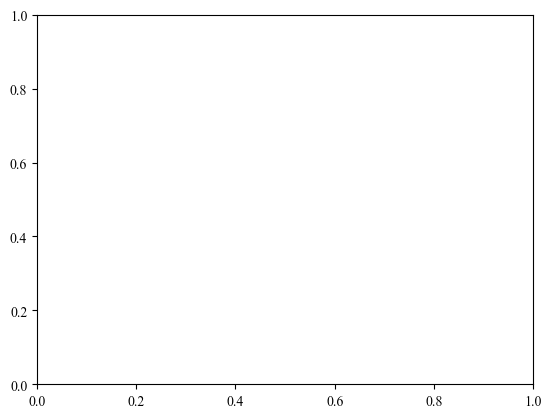

In [23]:
## LOW GAIN
runDarkFrameAnalysis("low", N=50, fps=60)

16

In [ ]:
## Medium GAIN
runDarkFrameAnalysis("medium", N=25)

Gain set to: high - Wellsize: 38000.0 e-
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Set integration time to 0.011
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 1118, std: 175
FPA actual temp: 20.0
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 3
mean: 963, std: 135
FPA actual temp: 20.0
 
Set integration time to 4.222222222222222
Int. Time set to: 4.22ms
......................... 
Num of dead pixels: 6
mean: 975, std: 136
FPA actual temp: 20.0
 
Set integration time to 7.444444444444445
Int. Time set to: 7.44ms
......................... 
Num of dead pixels: 9
mean: 1005, std: 143
FPA actual temp: 20.0
 
Set integration time to 10.666666666666668
Int. Time set to: 10.67ms
......................... 
Num of dead pixels: 17
mean: 1035, std: 149
FPA actual temp: 20.0
 
Set integration time to

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/365201148.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


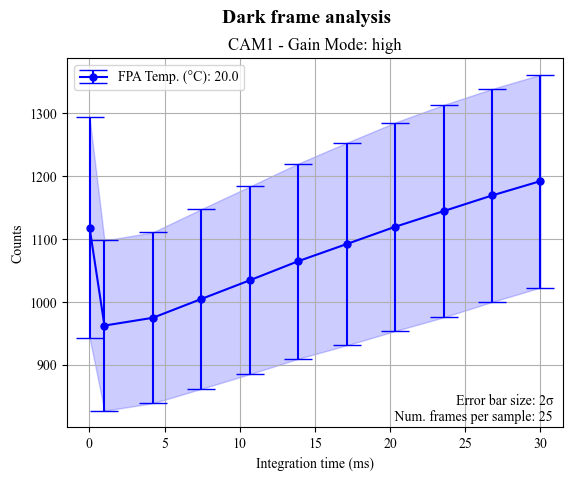

In [129]:
## High GAIN
runDarkFrameAnalysis("high", N=25)